In [1]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist
#if these last 2 don't work might need to do nltk.download(package)
import re
from bs4 import BeautifulSoup
import unicodedata

from string import punctuation
from collections import Counter
import numpy as np

In [2]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()


# allow plots to appear in the notebook
%matplotlib inline


## Import and Clean Connect Report

In [4]:
report=pd.read_csv('connect_report.csv')

report['Created Date']=pd.to_datetime(report['Created Date'])
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


## Report Generator

In [5]:
final_report=pd.DataFrame

#Use this function to create the final report
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: )
# 4. Set End Date or leave blank(defaults to: )

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        #alt approach-- not working but not sure why-- it worked it worked it worked! had to change the data type to all be annoying ass datatime64... down the line that might be a pain but for now it's dope
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)

final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-02-01","2017-03-01")

final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post


## Tokenizer Function

In [6]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")

wnl = WordNetLemmatizer() 

In [7]:
#this function tokenizes text, removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
 
    return filtered_tokens

In [8]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)
#final_report['tokens'][0:10]

In [9]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

unlisted_report=final_report['tokens'].apply(lambda x: ', '.join(x))

word_vectorizer_2=CountVectorizer(ngram_range=(1,2), analyzer='word')
word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit_2).toarray()[0]

bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
f = bigrams_counter[bigrams_counter['frequency']>10]
top_words_test=f.sort_values(by=['frequency'],ascending=False)
top_words_test=top_words_test.head(15)

#The tokenizer cuts it down significantly to 639


##how can we integrate bigrams into the keywords functions-- we have identified the most common ones, how do we match them up with the original body comments?
#print(word_vectorizer_fit_2.shape)
#print(f.sort_values(by=['frequency'],ascending=False))
##bigrams are F'd up here--- why does it return things like practice practice or patient patient?




In [10]:
#Can we do this by day??? #Take a list of the top 10 most frequent words (or whatever) and then track their usage throughout the report period.
def single_day_tracker(report):
    #Create the top 10 list
    unlisted_report=report['tokens'].apply(lambda x: ', '.join(x))

    word_vectorizer_2=CountVectorizer(ngram_range=(1,2), analyzer='word')
    word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit_2).toarray()[0]

    bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
    f = bigrams_counter[bigrams_counter['frequency']>10]
    
   
    f=f.sort_values(by=['frequency'],ascending=False)
    top_words=f.head(15)
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=unlisted_report=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer_2.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)


            
            
top_words=single_day_tracker(final_report)

top_words




C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,frequency,word,date
0,1,care,2017-02-03
1,1,click,2017-02-03
2,2,group,2017-02-03
3,1,payment,2017-02-03
4,2,post,2017-02-03
5,2,practice,2017-02-03
6,1,click,2017-02-07
7,3,patient,2017-02-08
8,2,post,2017-02-08
9,6,practice,2017-02-08


In [11]:
#extends tokens list with bi-grams for each row
for i,t in final_report['Body'].iteritems():
    
    t_list = word_tokenize(t.lower())
    t_list = list(filter(lambda t: t not in stop, t_list))
    t_list = list(filter(lambda t: t not in punctuation, t_list))
    
    lem_list = []
    for t in t_list:
        t = wnl.lemmatize(t)
        lem_list.append(t)
        
    text=" ".join(lem_list)
    
    ng = [ngrams(word_tokenize(sent),2) for sent in sent_tokenize(text.lower())]
    n_gram = []
    for n in ng:
            n_gram += n
    two_grams = []        
    for n in n_gram:
            new = ' '.join(n)
            two_grams.append(new)
    final_report['tokens'][i].extend(two_grams)

## Keyword Retrieval

In [12]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [13]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10))
    print

does everyone have portal access

[('access', 1), ('everyone portal', 1), ('everyone', 1), ('portal', 1), ('portal access', 1)]

I am trying to figure out how to document/track our use of the CMF payments. I was wondering if we will just be required to submit an excel document with our expenditures or will additional documentation be required? I have looked everywhere to find clarification and am not seeing anything. Any thoughts? 

[('required', 2), (u'document/track use', 1), ('seeing', 1), ('documentation', 1), ('figure', 1), (u'cmf payment', 1), (u'wondering required', 1), (u'use cmf', 1), (u'looked everywhere', 1), (u'expenditure additional', 1)]

We appreciate your participation in the Care Management Webinar. Click to download the webinar slides, post additional questions and continue the conversation with others here. A video recording will be forthcoming next week.

[('webinar', 2), (u'recording forthcoming', 1), (u'video recording', 1), ('video', 1), (u'conversation others', 

In [14]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [15]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('category :', t)
    print('top 10 keywords:', keywords_bytype(t))
    print('---')

('category :', 'Advanced Text Post')
('top 10 keywords:', [('announcement', 3), ('important', 2), ('important announcement', 2), ('feed', 1), ('set', 1), ('show', 1), (u'check february', 1), (u'http //app.innovation.cms.gov/cpcplusconnect/sfc/', 1), ('newsletter', 1), (u'newsletter http', 1)])
---
('category :', 'Link Post')
('top 10 keywords:', [(u'group', 14), (u'practice', 11), ('step', 10), ('risk', 9), ('health', 9), ('click', 7), ('join', 7), (u'payer', 6), ('care', 6), (u'cm', 6)])
---
('category :', 'Text Post')
('top 10 keywords:', [(u'practice', 24), (u'patient', 14), ('group', 13), ('care', 11), ('risk', 9), (u'measure', 8), (u'payment', 8), ('report', 8), ('portal', 8), ('performance', 8)])
---
('category :', 'Poll')
('top 10 keywords:', [(u"'s better", 2), ('better', 2), ('link', 2), ('file', 2), (u'file posting', 1), ('downloading', 1), ('posting', 1), ('better file', 1), (u'better link', 1), ('link downloading', 1)])
---
('category :', 'Content Post')
('top 10 keywords:'

## TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [17]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=2, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [18]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [19]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
practice,1.965081
care,2.504077
patient,2.745239
check,2.840550
share,2.945910
group,2.945910
would,3.063693
available,3.063693
cm,3.063693
question,3.063693


In [20]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

,tfidf
appreciate participation,4.044522
survey give,4.044522
partnering cm,4.044522
intuition,4.044522
timely information,4.044522
recording forthcoming,4.044522
give u,4.044522
population,4.044522
comment,4.044522
word follower,4.044522


## Correlated Words

In [21]:
##Constructing a collocation finder

finder=BigramCollocationFinder.from_documents(final_report['Body'].apply(tokenizer))
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)


[("'d", 'ask'), ('//app.innovation.cms.gov/cpcplusconnect/sfc/', 'version'), ('aafp', "'risk-stratified"), ('actually', 'create'), ('addprogram', u'administrator'), ('adjust', 'risk-stratification'), ('ago', 'heard'), ('anomaly', 'expect'), ('arkansas', 'blue'), ('around', 'specific'), ('ask', 'well'), ('assume', "'m"), ('athena', 'wanting'), ('awaiting', 'response'), ('based', 'defined')]


In [30]:
##Using tokens
##use when bi-gram tokens are fixed

finder_2=BigramCollocationFinder.from_documents(final_report['tokens'])
score_collocation_2=finder_2.nbest(bigram_measures.pmi,15)

print(score_collocation_2)

[(u"'' medicare", u"medicare 's"), (u"'' read", u'read side'), (u"'' tab", u'tab could'), ("'d", 'ask'), (u"'d ask", u'ask well'), (u"'m using", u'using claim'), (u"'re hard", u'hard time'), (u"'s 'risk-stratified", u"'risk-stratified care"), (u"'s assume", u"assume 'm"), (u"'s attributed", u'attributed u'), (u"'s available", u'available assist'), ("'s ehr", 'ehr already'), ("'s emr", 'emr athena'), (u"'s latter", u'latter look'), (u"'s payment", u'payment could')]


In [29]:
##SO RIGHT NOW finder works a lot better than Finder 2 (using body and applying the tokenizer as opposed to just using the toekns... why is that?

scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[1:10])

[("'m", 'using'), ("'re", 'hard'), ("'re", 'willing'), ("'risk-stratified", 'care'), ('//app.innovation.cms.gov/cpcplusconnect/sfc/', 'version'), ('50th', 'percentile'), ('80th', 'percentile'), ('aafp', "'risk-stratified"), ('able', 'assist')]


In [31]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [32]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('management','care','single')

[(504, (('management', u'fee'), 7.326429487122304)),
 (535, (('self', 'management'), 7.326429487122304)),
 (723, (("'risk-stratified", 'care'), 6.004501392234942)),
 (725, ((u'administrator', 'care'), 6.004501392234942)),
 (727, (('care', u'coordinator'), 6.004501392234942)),
 (728, (('care', 'plan'), 6.004501392234942)),
 (729, (('care', 'redesign'), 6.004501392234942)),
 (730, (('care', 'utilization'), 6.004501392234942)),
 (734, (('experience', 'care'), 6.004501392234942)),
 (736, (('hub', 'care'), 6.004501392234942)),
 (737, (('impression', 'care'), 6.004501392234942)),
 (738, (('include', 'care'), 6.004501392234942)),
 (751, (('pay', 'care'), 6.004501392234942)),
 (752, (('primary', 'care'), 6.004501392234942)),
 (753, (('quarterly', 'care'), 6.004501392234942)),
 (754, (('received', 'care'), 6.004501392234942)),
 (757, ((u'seam', 'care'), 6.004501392234942)),
 (784, (('care', 'management'), 5.811856314292546)),
 (786, (('management', 'coordination'), 5.741466986401147)),
 (787, (

In [33]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words

#Actually isn't measuring correlation, but PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)... 
#basically it sounds like measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score
try:
    print("The association between the two words is",scored[word_finder("able","assist")][1])
except:
    print("Choose a new word pair!")

('The association between the two words is', 7.326429487122304)


In [34]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    sns.mpl.rc("figure", figsize=(9,4))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    #tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    #plugins.connect(word_graph,tooltip)


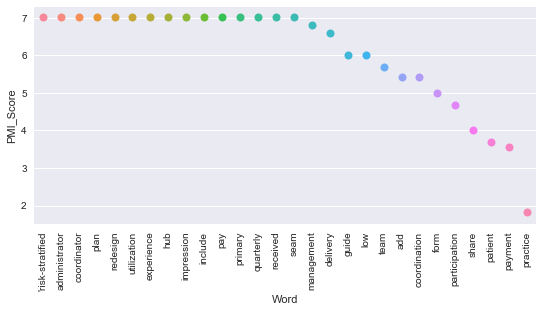

In [28]:
graphing_single_word_finder('care',mode='single')


#so pretty... have to figure out how to clean up the axis/distingish the dots (tooltip not working)

In [29]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



7.006746832440585

In [35]:
##Graphing most popular word by day

test_date=top_words['date'][0]

#sns.pointplot(x='date',y='frequency',hue='word',data=top_words)

##okay so this is super busy but we're getting there

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))



test_float=float(test_date.month)+(float(test_date.day)/100)

test_float

##There must be a faster/better way to do this

top_words['new_date']=float

for i in xrange(0,len(top_words['date'])):
    top_words['new_date'][i]=float(top_words['date'][i].month)+(float(top_words['date'][i].day)/100)
    


C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
sns.set_palette('Set1')

#Hmmm this doesn't work for some reason

(2.02, 2.3)

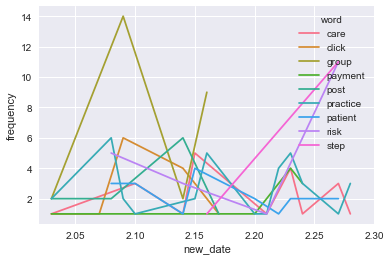

In [50]:
top_words['frequency']=top_words['frequency'].astype(float)

top_words

top_words.dtypes
ax=sns.tsplot(time='new_date',value='frequency',condition='word',unit='word',data=top_words)

#Top 10 words might just be too busy... top 5 might look a lot better, but got it to work :)
#also not a huge fan of the color pallete here... too many similar colors
#will need to figure out how to do some auto scaling on the plt xlim to get a better view than the default
plt.xlim(2.02,2.3)



[(0.89411764705882346, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.49411764705882361, 0.72156862745098038),
 (0.30196078431372558, 0.68627450980392157, 0.29019607843137263),
 (0.59607843137254923, 0.30588235294117649, 0.63921568627450975),
 (1.0, 0.49803921568627452, 0.0),
 (0.99999999999999978, 1.0, 0.19999999999999996),
 (0.65098039215686287, 0.33725490196078434, 0.1568627450980391),
 (0.96862745098039216, 0.50588235294117656, 0.74901960784313737),
 (0.59999999999999998, 0.59999999999999998, 0.59999999999999998)]

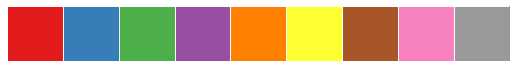

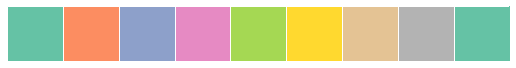

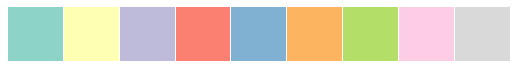

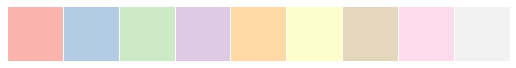

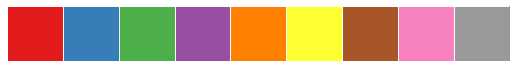

In [42]:
sns.choose_colorbrewer_palette('qualatative')